In this example we perform cross-checks on:
- The deposition fraction $f_c$,
- The ionization level x_e(z), and
- the CMB distortion.

In [1]:
# Generic imports
import csv
import pickle
import sys
sys.path.append('../..')

from scipy.interpolate import interp1d

from tqdm.notebook import tqdm

In [4]:
# DarkHistory imports
import darkhistory.physics as phys
from config import load_data
import main

import darkhistory.electrons.elec_cooling as elec_cooling
from   darkhistory.spec.spectools import EnglossRebinData
from darkhistory.electrons.elec_cooling import get_elec_cooling_tf

from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.spec.spectools as spectools
import darkhistory.low_energy.lowE_electrons as lowE_elec
import darkhistory.utilities as utils

import darkhistory.low_energy.atomic as atomic
import darkhistory.low_energy.bound_free as bf

import darkhistory.history.tla as tla

from plotting_utils import plot_distortion, download_plot

hplanck = phys.hbar * 2*np.pi

In [3]:
fig_dir = '/Users/gregoryridgway/Dropbox (MIT)/DarkHistory_V2/Drafts/figs/'
#fig_dir='/Users/gregoryridgway/Desktop/DHv2/DH_Upgrade_Papers/figs/'
savefig=False

input_dir = '/Users/gregoryridgway/Desktop/Webplot Digitizer/DHv2/'
output_dir = '/Users/gregoryridgway/Desktop/Data/'

# 1. $f_c(z)$ Old vs. New

In this upgrade of DarkHistory we change our treatment of low energy electrons.  Rather than separating out sub-3keV electrons and applying MEDEA's interpolation files to determine the fractions of energy they deposit into each channel, we solve for their deposited energy directly.  Plugging this new treatment into main.evolve() generates a new set of $f_c(z)$.  We compare our new $f_c(z)$ to Fig. 18 of [1904.09296](https://arxiv.org/pdf/1904.09296.pdf).

In [111]:
import darkhistory.low_energy.atomic as atomic
nmax = 20
R = atomic.populate_radial(nmax)

In [112]:
rs_list = np.exp(np.arange(np.log(3e3), np.log(100), -.001*16))
rate2s1s_list = np.zeros_like(rs_list)
for i,rs in enumerate(rs_list):
    _, BB_2s1s = atomic.populate_bound_bound(nmax, phys.TCMB(rs), R)
    rate2s1s_list[i] = BB_2s1s['dn']

Text(0.5, 0, 'Redshift, $1+z$')

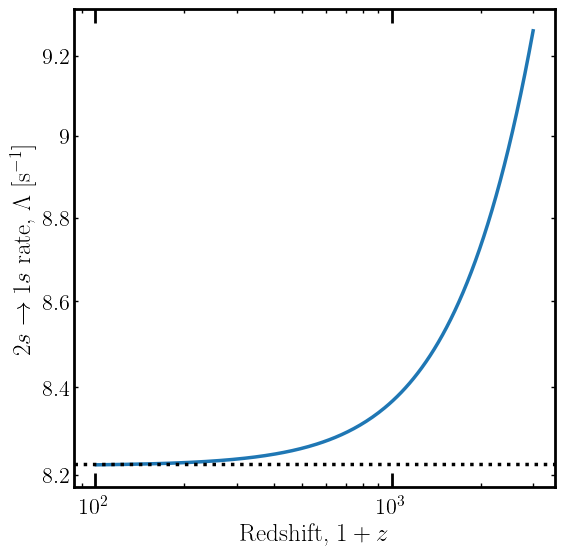

In [117]:
plt.figure()
plt.loglog()
plt.plot(rs_list, rate2s1s_list10, label='nmax = 10')
# plt.plot(rs_list, rate2s1s_list20, label='nmax = 20')
plt.axhline(phys.width_2s1s_H, color='k', linestyle=':')
# plt.legend()
plt.ylabel(r'$2s \to 1s$ rate, $\Lambda$ [s$^{-1}$]')
plt.xlabel(r'Redshift, $1+z$')

In [213]:
def log10eng_to_mDM(log10eng, pri, DM_process):
    # Converts from log10eng to mDM
    
    if pri=='elec':
        if DM_process=='decay':
            mDM_list = 2*(10**log10eng + phys.me)

        else:
            mDM_list = 10**log10eng + phys.me

    elif pri=='phot':
        if DM_process=='decay':
            mDM_list = 2*10**log10eng
        else:
            mDM_list = 10**log10eng
            
    return mDM_list


# Energy of injected particle
log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = 12.601505994846297
eng = 10**log10eng

In [227]:
fs_data = {}
for pri in ['elec', 'phot']:
    for DM_process in ['decay', 'swave']:
        key = pri+'_'+DM_process
        fs_data[key] = []

        mDM_list = log10eng_to_mDM(log10eng, pri, DM_process)

        for mDM in mDM_list:
            res = main.evolve(
                DM_process=DM_process, mDM=mDM,
                lifetime=1e40, sigmav=1e-40, primary=pri+'_delta',
                start_rs=3e3, high_rs=1.555e3, end_rs=5,
                coarsen_factor=16, 
                # Set distort to True to force elec_processes=True
                # even when pri='phot'
                distort=True, recfast_TLA=True, nmax=10
            )
            fs_data[key].append(res['f'])


pickle.dump(fs_data, open(output_dir+'fs_OLD_vs_NEW_xcheck.dat', 'wb'))

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

In [242]:
def get_fdiff(pri, DM_process, channel, ax, row, col):
    
    ind = {'H ion' : 0, 'He ion' : 1, 'Lya' : 2, 'heat' : 3, 'cont' : 4}[channel]
    ch_std = ['H ion', 'He ion', 'exc', 'heat', 'cont']
    ch_run = ['H ion', 'He ion', 'Lya', 'heat', 'cont']
    
    rs_tmp = np.exp(np.arange(np.log(3e3), np.log(5), -.001*16))
    
    mDM_list = log10eng_to_mDM(log10eng, pri, DM_process)
    
    f_NEW = np.ones((eng.size, rs_tmp.size-2))*1e-6
    f_OLD = np.ones((eng.size, rs_tmp.size-2))*1e-6
    
    key = pri+'_'+DM_process
    
    for m_ind in np.arange(eng.size-1):
        f_NEW[m_ind] = fs_data[key][m_ind][ch_run[ind]][2:]
        f_OLD[m_ind] = phys.f_std(mDM_list[m_ind], rs_tmp[2:], 
                              pri, DM_process, channel=ch_std[ind])
    
    if ind < 2:
        label = {'H ion' : 'H_{ion}', 'He ion' : 'He_{ion}'}[channel]
        
    else:
        label = channel
        
    title = r'\bf{$f_{'+label+'}$}'

    ax.loglog()
    
    levels=[0,.01,.05,.1,.2,.5,1.]#,.2,.3,.4,.5,1]
    
    diffs = np.zeros_like(f_NEW)
    diffs = np.abs(f_NEW - f_OLD)/f_NEW
    
    cs = ax.contourf(eng, rs_tmp[2:], np.transpose(diffs), levels = levels,
                     cmap=matplotlib.cm.RdBu_r)
        
    if row==0:
        ax.set_title(title)
    
    if col==0:
        ax.set_ylabel(r'Redshift ($1+z$)')
        
    if row==3:
        ax.set_xlabel(r'Kinetic Energy [eV]')
        
        if col==0:
            cbar = plt.colorbar(cs, ticks=levels)

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_41625/719452435.py:49: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(cs, ticks=levels)


<Figure size 620x620 with 0 Axes>

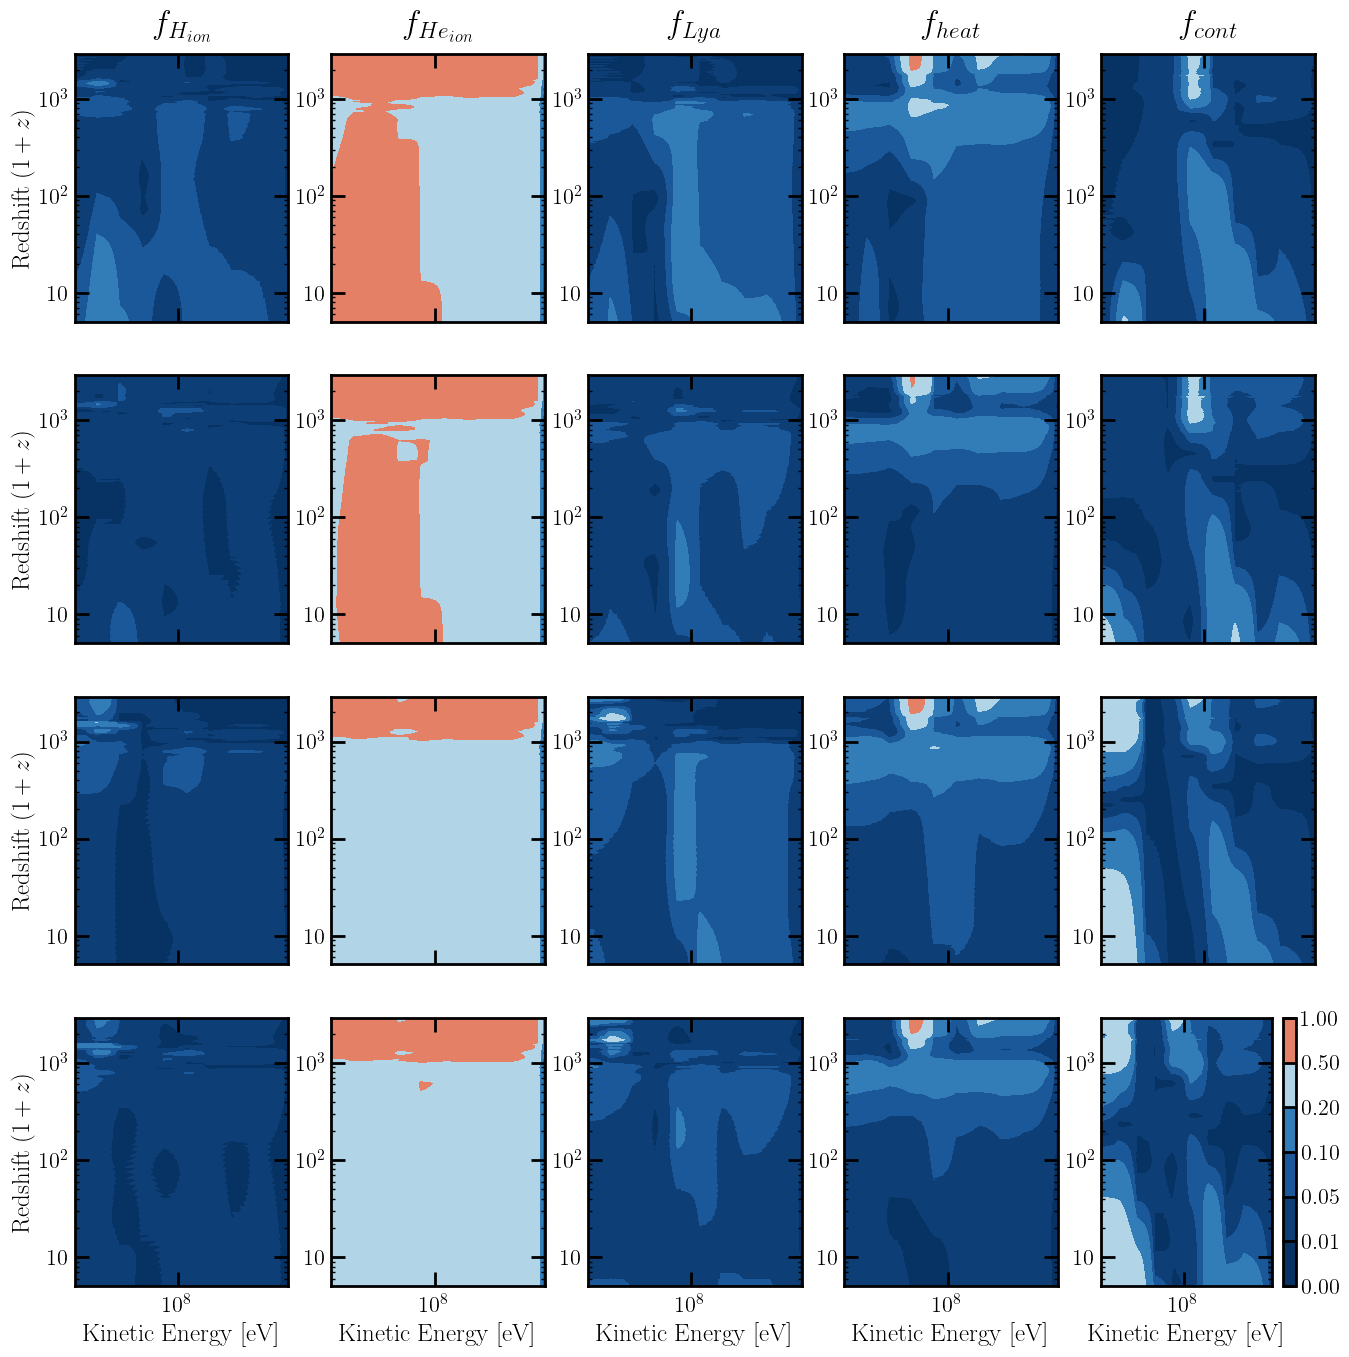

In [244]:
plt.figure()
f, axarr = plt.subplots(4,5, figsize = (16, 16), sharex=True)

row = 0
for pri in ['elec', 'phot']:
    for DM_process in ['decay', 'swave']:
        
        for col, chan in enumerate(['H ion', 'He ion', 'Lya', 'heat', 'cont']):
            get_fdiff(pri, DM_process, chan, axarr[row][col], row, col)
            
        row += 1
    
    
# f.tight_layout()
# if savefig:
plt.savefig(fig_dir+'f_heatmap_crosscheck.pdf')

# 2. $R_c(E')$ vs. MEDEA

An electron of energy $E'$ injected into the IGM will lose its energy through a number of different channels $c$. We define the fraction of energy that the electron lost to a given channel as $R_c(E')$. In this cross-check we compare our computation of $R_c(E')$ to [MEDEA's data tables](https://doi.org/10.1111/j.1365-2966.2012.20624.x).

In [33]:
# Load data.
binning = load_data('binning')
photeng = binning['phot']
eleceng = binning['elec']

dep_tf_data = load_data('dep_tf')

ics_tf_data = load_data('ics_tf')

ics_thomson_ref_tf  = ics_tf_data['thomson']
ics_rel_ref_tf      = ics_tf_data['rel']
engloss_ref_tf      = ics_tf_data['engloss']

#MEDEA
H_states = ['2s', '2p', '3p', '4p', '5p', '6p', '7p', '8p', '9p', '10p']

(
    coll_ion_sec_elec_specs, coll_exc_sec_elec_specs,
    ics_engloss_data
) = main.get_elec_cooling_data(eleceng, photeng, H_states=H_states)

In [34]:
%autoreload
# Probs that a given state decays ultimately to '2p'
# See Table I of astro-ph/0507102
Ps = {'2p': 1.0000, '2s': 0.0, '3p': 0.0,
      '4p': 0.2609,'5p': 0.3078,'6p': 0.3259,
      '7p': 0.3353,'8p': 0.3410,'9p': 0.3448,'10p': 0.3476}

#ionization levels probed by MEDEA
xes = np.array([
    1e-4, 1.5e-4, 2e-4, 3e-4, 5e-4,
    1e-3, 1.5e-3, 2e-3, 3e-3, 5e-3,
    1e-2, 1.5e-2, 2e-2, 3e-2, 5e-2,
    1e-1, 1.5e-1, 2e-1, 3e-1, 5e-1,
    7e-1, 8e-1, 9e-1, 9.5e-1, 9.9e-1, 
    1.0
])

channels = ['heat', 'exc', 'H ion', 'He ion', 'cont']
fs = {chan: np.zeros((xes.size, eleceng.size)) for chan in channels}

In [40]:
%autoreload
rs=1
for i,xHII in enumerate(tqdm(xes)):
    (
        ics_sec_phot_tf,
        deposited_ion_arr, deposited_exc_arr, deposited_heat_arr,
        deposited_ICS_arr, ICS_err_arr
    ) = get_elec_cooling_tf(
            eleceng, photeng, rs,
            xHII, xHeII=xHII * phys.chi,
            raw_thomson_tf=ics_thomson_ref_tf,
            raw_rel_tf=ics_rel_ref_tf,
            raw_engloss_tf=engloss_ref_tf,
            coll_ion_sec_elec_specs=None,
            coll_exc_sec_elec_specs=None,
            ics_engloss_data=ics_engloss_data, 
            H_states=H_states,
            check_conservation_eng=True
        )

    fs['heat'][i]   = deposited_heat_arr/eleceng
    fs['H ion'][i]  = deposited_ion_arr['H']/eleceng
    fs['He ion'][i] = deposited_ion_arr['He']/eleceng
    
    fs['exc'][i]  = np.sum([
        deposited_exc_arr[species]*Ps[species] * phys.lya_eng/phys.H_exc_eng(species)
    for species in Ps], axis=0)/eleceng

    fs['cont'][i] = np.sum([
        deposited_exc_arr[species]*(1-Ps[species]) * (1+1-phys.lya_eng/phys.H_exc_eng(species))
    for species in Ps], axis=0)/eleceng + (
    deposited_ICS_arr/eleceng)

  0%|          | 0/26 [00:00<?, ?it/s]

In [43]:
%autoreload
rs=1
for i,xHII in enumerate(tqdm(xes)):
    (
        ics_sec_phot_tf,
        deposited_ion_arr, deposited_exc_arr, deposited_heat_arr,
        deposited_ICS_arr, ICS_err_arr
    ) = get_elec_cooling_tf(
            eleceng, photeng, rs,
            xHII, xHeII=xHII * phys.chi,
            raw_thomson_tf=ics_thomson_ref_tf,
            raw_rel_tf=ics_rel_ref_tf,
            raw_engloss_tf=engloss_ref_tf,
            coll_ion_sec_elec_specs=None,
            coll_exc_sec_elec_specs=None,
            ics_engloss_data=ics_engloss_data, 
            H_states=H_states,
            check_conservation_eng=True
        )

    fs['heat'][i]   = deposited_heat_arr/eleceng
    fs['H ion'][i]  = deposited_ion_arr['H']/eleceng
    fs['He ion'][i] = deposited_ion_arr['He']/eleceng
    
    fs['exc'][i]  = np.sum([
        deposited_exc_arr[species]*Ps[species] * phys.lya_eng/phys.H_exc_eng(species)
    for species in Ps], axis=0)/eleceng

    fs['cont'][i] = np.sum([
        deposited_exc_arr[species]*(1-Ps[species]) * (1+1-phys.lya_eng/phys.H_exc_eng(species))
    for species in Ps], axis=0)/eleceng + (
    deposited_ICS_arr/eleceng)

  0%|          | 0/26 [00:00<?, ?it/s]

In [44]:
our_fs = np.array([fs[chan] for chan in channels])
our_fs = our_fs.swapaxes(0,2)
our_fs = our_fs.swapaxes(0,1)

MEDEA_interp = lowE_elec.make_interpolator()
DH_interp = utils.Interpolator2D(
    xes, 'xes', eleceng, 'engs', our_fs, logInterp=True
)

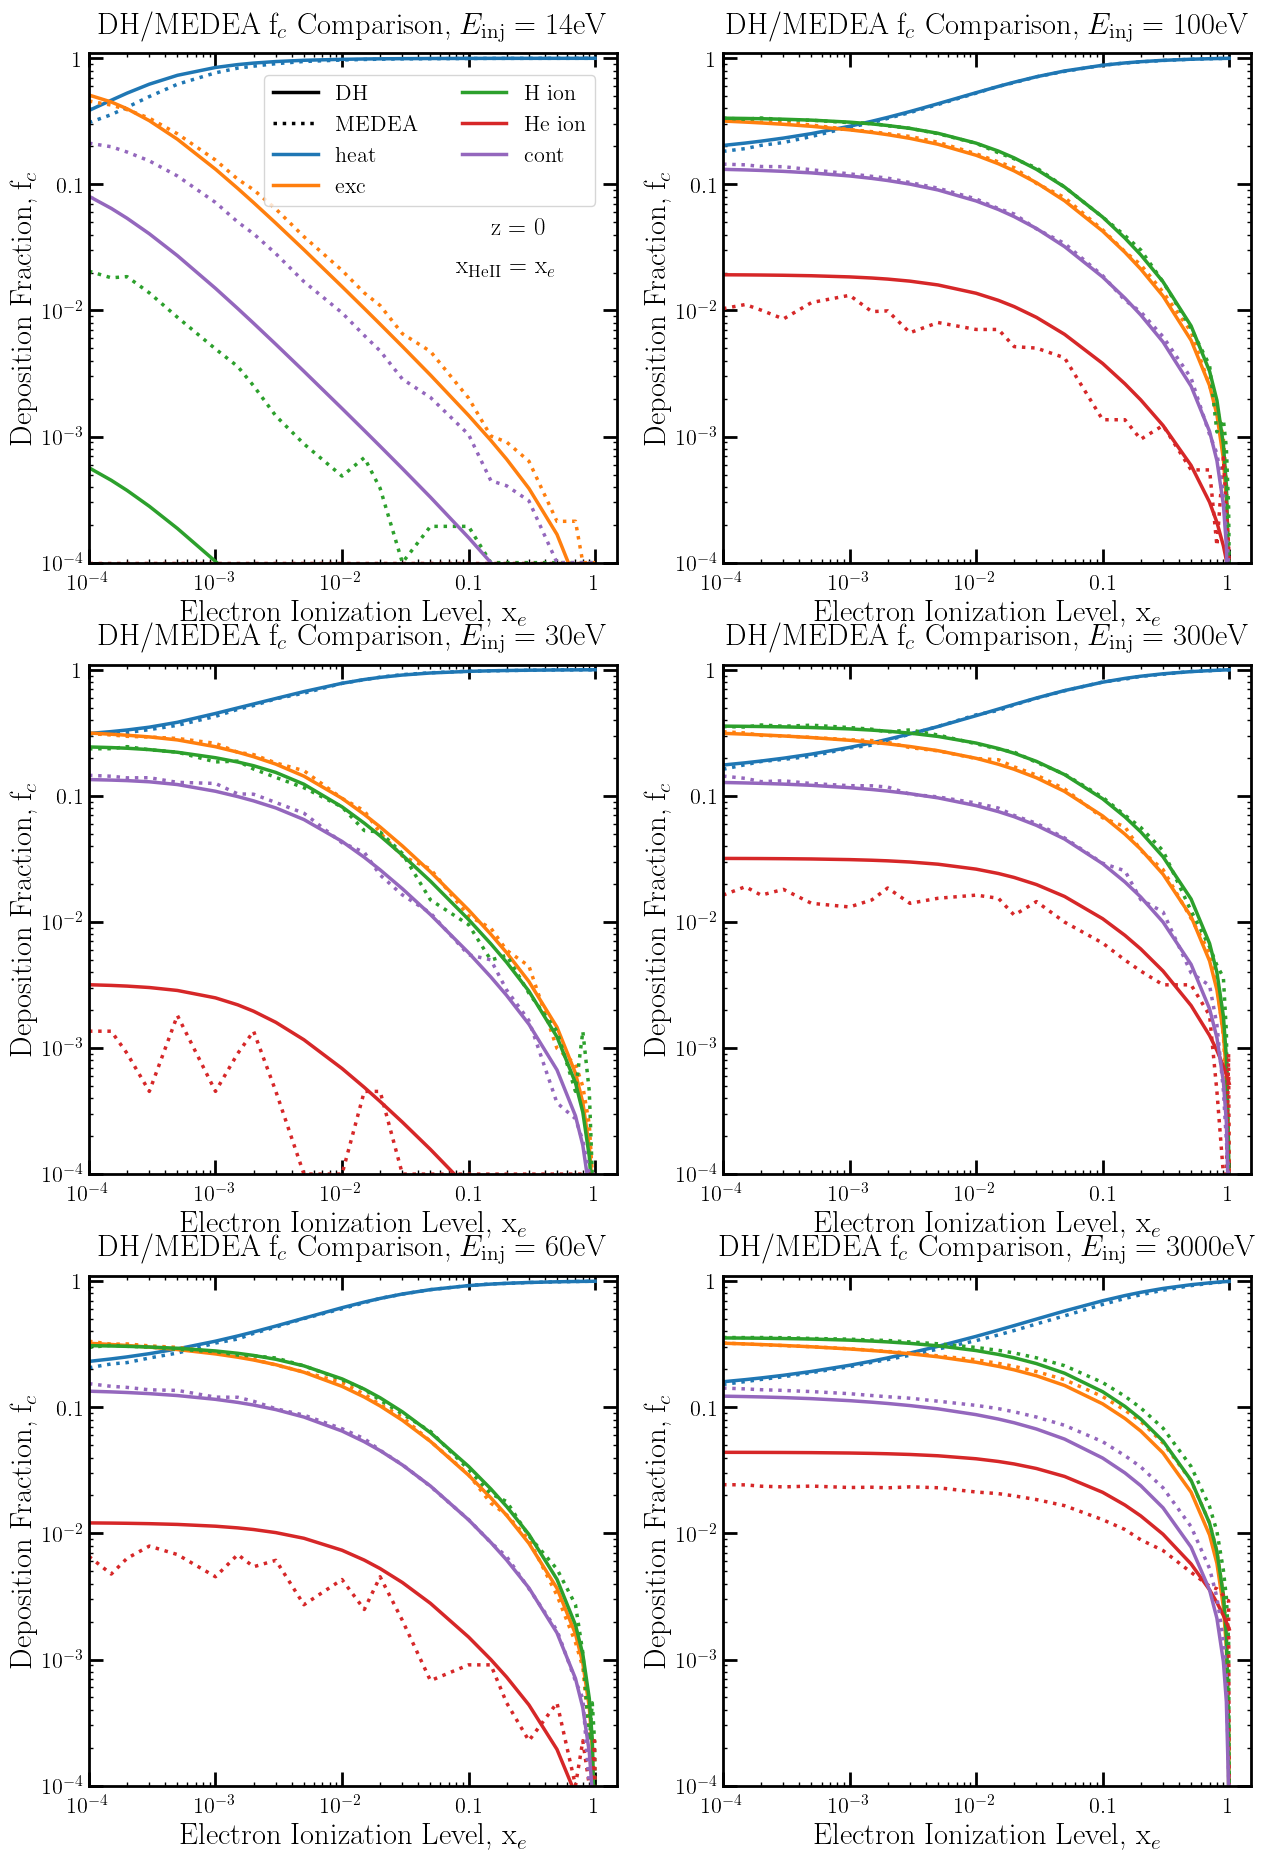

In [45]:
initEs = np.array([14, 30, 60, 100, 300, 3000])
n_fig_col = 3
fig, axarr = plt.subplots(3, int(initEs.size/n_fig_col),
                          figsize=(7.5*initEs.size/n_fig_col, n_fig_col*7.5))
for i, initE in enumerate(initEs):
    j = int(i%n_fig_col)
    k = int(np.floor(i/n_fig_col))
    DH_data = DH_interp.get_vals(xes,initE)
    MEDEA_data = MEDEA_interp.get_vals(xes,initE)

    axarr[j][k].loglog()
    axarr[j][k].plot(xes, np.ones_like(xes)*1e-20, color='k', label='DH')
    axarr[j][k].plot(xes, np.ones_like(xes)*1e-20, color='k', linestyle=':', label='MEDEA')

    for j1 in np.arange(5):
        axarr[j][k].plot(xes, DH_data[:,j1], color='C'+str(j1), label=channels[j1])
        axarr[j][k].plot(xes, MEDEA_data[:,j1], color='C'+str(j1), linestyle=':')

    axarr[j][k].axis([1e-4, 1.5, 1e-4,1.1])
    axarr[j][k].set_title(r'DH/MEDEA f$_c$ Comparison, $E_{\mathrm{inj}} = '+str(initE)+'$eV', fontsize=22)
    axarr[j][k].set_xlabel(r'Electron Ionization Level, x$_e$', fontsize=22)
    axarr[j][k].set_ylabel(r'Deposition Fraction, f$_c$', fontsize=22)
    if i!=1:
        leg_y = 4e-3
    else:
        leg_y = 7e-3
        
    if i == 0:
        leg_y = 0.04
        axarr[j][k].text(1.5e-1, leg_y, r'z = '+str(rs-1), fontsize = 18)
        axarr[j][k].text(8e-2, leg_y/2, r'x$_{\mathrm{HeII}}$ = x$_e$', fontsize = 18)
        axarr[j][k].legend(ncol=2)
    
if savefig:
    plt.savefig(fig_dir+'MEDEA_CrossCheck.pdf')

# 3. $R_c(E')$ vs. Acharya+Khatri

We perform the same cross-check above, but now against Fig. 1 of [1910.06272](https://arxiv.org/pdf/1910.06272.pdf).

In [51]:
files = ['heat', 'ICS', 'He ion', 'H ion', 'H exc2', 'H exc3', 'He exc']
Acharya_f = {'04': {}, '0002': {}}
for num in ['04', '0002']:
    for f in files:
        Acharya_f[num][f] = []
        with open('/Users/gregoryridgway/Desktop/Webplot Digitizer/Distortions/'
                  +'Acharya'+num+'/'+f+'.csv') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                Acharya_f[num][f].append([float(row[0]),float(row[1])])
        Acharya_f[num][f] = np.array(Acharya_f[num][f])
        Acharya_f[num][f] = interp1d(Acharya_f[num][f][:,0], Acharya_f[num][f][:,1],
                                    bounds_error=False, fill_value=(1e-10,1e-10))

In [52]:
eleceng, photeng = binning['elec'], binning['phot']
H_states  = ['2s', '2p', '3p']

(
    coll_ion_sec_elec_specs, coll_exc_sec_elec_specs, ics_engloss_data
) = main.get_elec_cooling_data(eleceng, photeng, H_states=H_states)

simple_ICS = True
DH_f = {'04': {}, '0002': {}}
for i, num in enumerate(['04', '0002']):
    if num == '04':
        xHII = 4e-2
        rs = 1001
    else:
        xHII = 2e-4
        rs=101
        
    (
        ics_sec_phot_tf,
        deposited_ion_arr, deposited_exc_arr, deposited_heat_arr,
        deposited_ICS_arr, ICS_err_vec
    ) = get_elec_cooling_tf(
            eleceng, photeng, rs,
            xHII, xHeII=0,
            raw_thomson_tf=ics_thomson_ref_tf,
            raw_rel_tf=ics_rel_ref_tf,
            raw_engloss_tf=engloss_ref_tf,
            coll_ion_sec_elec_specs=None,
            coll_exc_sec_elec_specs=None,
            ics_engloss_data=ics_engloss_data, 
            simple_ICS=simple_ICS,
            check_conservation_eng=False,
            H_states=H_states
    )
    
    DH_f[num]['heat'] = deposited_heat_arr/eleceng
#     if simple_ICS:
    DH_f[num]['ICS'] = deposited_ICS_arr/eleceng #(np.dot(ics_sec_phot_tf.grid_vals, photeng)-0*deposited_ICS_arr)/eleceng
#     else:
#         DH_f[num]['ICS']= np.dot(ics_sec_phot_tf.grid_vals, photeng)/eleceng
#     DH_f[num]['ICS']= np.dot(ics_sec_phot_tf.grid_vals, photeng)/eleceng
    DH_f[num]['He ion'] = deposited_ion_arr['He']/eleceng
    DH_f[num]['H ion']  = deposited_ion_arr['H']/eleceng
    DH_f[num]['H exc2'] = (deposited_exc_arr['2s']+deposited_exc_arr['2p'])/eleceng
    DH_f[num]['H exc3'] = deposited_exc_arr['3p']/eleceng
    DH_f[num]['He exc'] = (deposited_exc_arr['HeI']+deposited_exc_arr['HeII'])/eleceng

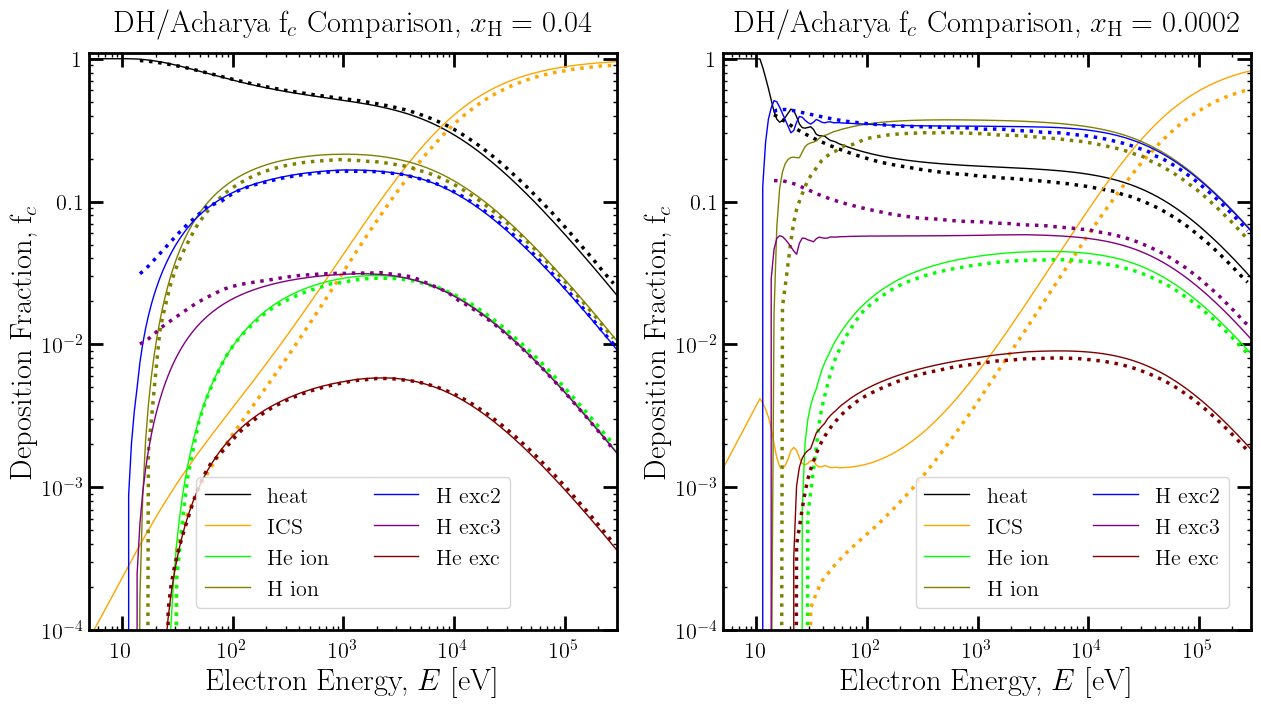

In [53]:
initEs = np.array([14, 30, 60, 100, 300, 3000])
fig, axarr = plt.subplots(1, 2, figsize=(15,7.5))
colors = {'heat':'k', 
              'ICS': 'orange', 
              'He ion': 'lime', 
              'H ion': 'olive', 
              'H exc2': 'blue', 
              'H exc3': 'purple', 
              'He exc': 'maroon'}
for i, num in enumerate(['04', '0002']):
    axarr[i].loglog()
    for f in files:
        ind1 = sum(eleceng<14)
        ind2 = sum(eleceng<2.93e5)
        axarr[i].plot(eleceng[ind1:ind2], Acharya_f[num][f](eleceng[ind1:ind2]),
                      color=colors[f], linestyle=':')
        axarr[i].plot(eleceng, DH_f[num][f], 
                      color=colors[f], linestyle='solid', linewidth=1, label=f)

    axarr[i].axis([5, 3e5, 1e-4,1.1])
    axarr[i].set_title(r'DH/Acharya f$_c$ Comparison, $x_{\mathrm{H}} = 0.$'+str(num), fontsize=22)
    axarr[i].set_xlabel(r'Electron Energy, $E$ [eV]', fontsize=22)
    axarr[i].set_ylabel(r'Deposition Fraction, f$_c$', fontsize=22)
    axarr[i].legend(ncol=2)
    
if savefig:
    plt.savefig(fig_dir+'AcharyaKhatri_CrossCheck.pdf')

# 4. $x_e(z)$ vs. Hyrec

Rather than use fitting functions with fudge factors for the recombination and photo-ionization coefficients, $\alpha_B$ and $\beta_B$, we now calculate them.  To test if we have done so correctly we calculate $x_e(z)$ and compare to the solid line in Fig. 3 of [1011.3758](https://arxiv.org/pdf/1011.3758.pdf), Hyrec's paper.

In [5]:
# Download Hyrec plots
EMLA_data = download_plot('EMLA', input_dir)
Rec_data = download_plot('Recfast', input_dir)

In [86]:
rs_list = np.exp(np.arange(np.log(2e3), np.log(1100), -.001*4))

baseline = tla.get_history(rs_list, high_rs=1.555e3,
                           fudge=1.0, gauss_fudge=False, rtol=1e-8)
fudge_1_14 = tla.get_history(rs_list, high_rs=1.555e3,
                             fudge=1.14, gauss_fudge=False, rtol=1e-8)

dist_eng = np.exp(np.linspace(np.log(hplanck*1e8), np.log(phys.rydberg), 10))

nmax_list = [50]#,50,100,200,300]

In [87]:
%autoreload

nmax_convergence_alt = {}
for nmax in nmax_list:
    R = atomic.populate_radial(nmax)
    Thetas = bf.populate_thetas(nmax)

    MLA_data = np.zeros((rs_list.size, 3))
    for i, rs in enumerate(tqdm(rs_list)):

        MLA_data[i], _ = atomic.process_MLA(
            rs, 1, phys.x_std(rs, 'HI'), 
            phys.Tm_std(rs), nmax, eng, R, Thetas
        )

    MLA_funcs = [interp1d(rs_list, MLA_data[:,i], fill_value='extrapolate')
                 for i in range(3)]

    nmax_convergence_alt[nmax] = tla.get_history(
        rs_list, high_rs=1.555e3,
        recfast_TLA=False, MLA_funcs=MLA_funcs,
        rtol=1e-8
    )

  0%|          | 0/150 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


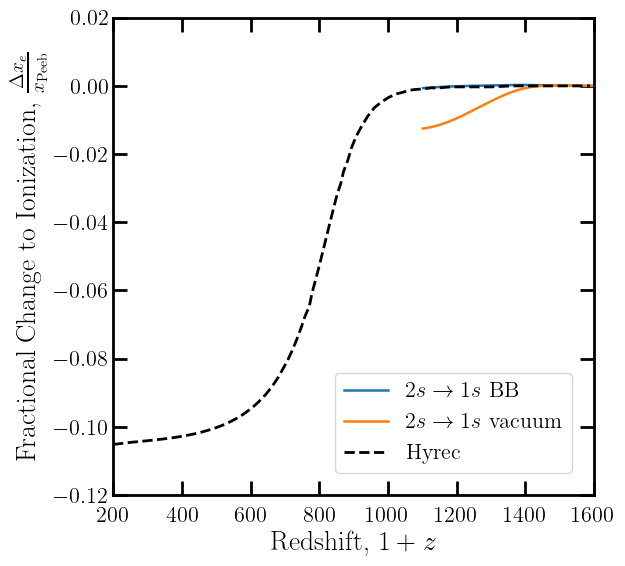

In [90]:
%autoreload
plt.figure()
plt.axis([200,1600, -.12,.02])
ax = plt.gca()

color = iter(plt.cm.PuRd(np.linspace(0.3, 1, len(nmax_list))))

# for i,nmax in enumerate(nmax_list):
#     c = next(color)
#     ax.plot(rs_list, nmax_convergence_alt[nmax][:,1]/baseline[:,1]-1, 
#              linewidth = 1.8, label=r'nmax='+str(nmax), c=c)
   

ax.plot(rs_list, nmax_convergence_alt[50][:,1]/baseline[:,1]-1, 
         linewidth = 1.8, label=r'$2s\to 1s$ BB')
ax.plot(rs_list, tmp/baseline[:,1]-1, 
             linewidth = 1.8, label=r'$2s\to 1s$ vacuum')

# hyrec plots
lw = 1.2
ax.plot(EMLA_data[:,0], EMLA_data[:,1], color='black', 
         linewidth = 2.0, linestyle = '--', 
         label=r'Hyrec')


# plot labels
ax.set_xlabel(r'Redshift, $1+z$', fontsize=20)
ax.set_ylabel(r'Fractional Change to Ionization, $\frac{\Delta x_e}{x_{\mathrm{Peeb}}}$', fontsize=20)
ax.legend()

if savefig:
    plt.savefig(fig_dir+'xe_crosscheck.pdf')

# 5. `distortion` vs. Jens+Sunyaev

Jens Chluba and collaborators have thoroughly computed the full Standard Model CMB distortion as well as various individual contributions.  In this cross-check we compare against Fig. 1 of [astro-ph/0608120](https://arxiv.org/pdf/astro-ph/0608120v1.pdf) and Fig. 3 of [astro-ph/0607373v1](https://arxiv.org/pdf/astro-ph/0607373v1.pdf) to test the bound-bound dipolar transitions, 1s-2s transition, and bound-free transitions.

In [106]:
# Create 2s -> 1s spectrum
eng = np.exp(np.linspace(
    np.log(hplanck*1e8), np.log(phys.rydberg), 500))

nmax_list = [10,20,30,100]

In [111]:
%autoreload
rs_vec = np.exp(np.arange(np.log(3.5e3), np.log(5e2), dlnz))

# Dictionary containing different types of distortions
distortion_dict = {}


for nmax in nmax_list:

    if nmax==100:
        include_2s1s, include_BF = True, True
    else:
        include_2s1s, include_BF = False, False


    key = str(nmax)
    if include_2s1s:
        key += '_2s'
    if include_BF:
        key += 'BF'

    if key not in distortion_dict:
        distortion_dict[key] = Spectrum(
            eng, np.zeros_like(eng), spec_type='N', rs=1)
    else:
        distortion_dict[key].N *= 0

    # Store individual components of the distortion
    delta_dists = Spectra(
        np.zeros((len(rs_vec), len(eng))), 
        eng=eng, spec_type='N', rs=rs_vec)

    R = atomic.populate_radial(nmax)
    Thetas = bf.populate_thetas(nmax)

    # Build up the distortion one redshift at a time
    for i, rs in enumerate(tqdm(rs_vec)):

        dt = -dlnz/phys.hubble(rs)
        xHI = phys.x_std(rs, 'HI')
        Tm = phys.Tm_std(rs)

        _, transition_spec = atomic.process_MLA(
            rs, dt, xHI, Tm, nmax, eng, R, Thetas,
            Delta_f=None, cross_check=False,
            include_2s1s=include_2s1s, include_BF=include_BF
        )

        delta_dists._grid_vals[i] = transition_spec.N
        transition_spec.redshift(1)
        distortion_dict[key] += transition_spec.N

  0%|          | 0/122 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

In [112]:
n10_data = download_plot('n10')
n20_data = download_plot('n20')
n30_data = download_plot('n30')
jens_data = download_plot('Full_Distortion')
jens_2s = download_plot('DeltaR_2s_jens')
jens_2p = download_plot('DeltaR_2p_jens')
BB_BF_jens = download_plot('BB_plus_BF_dist')

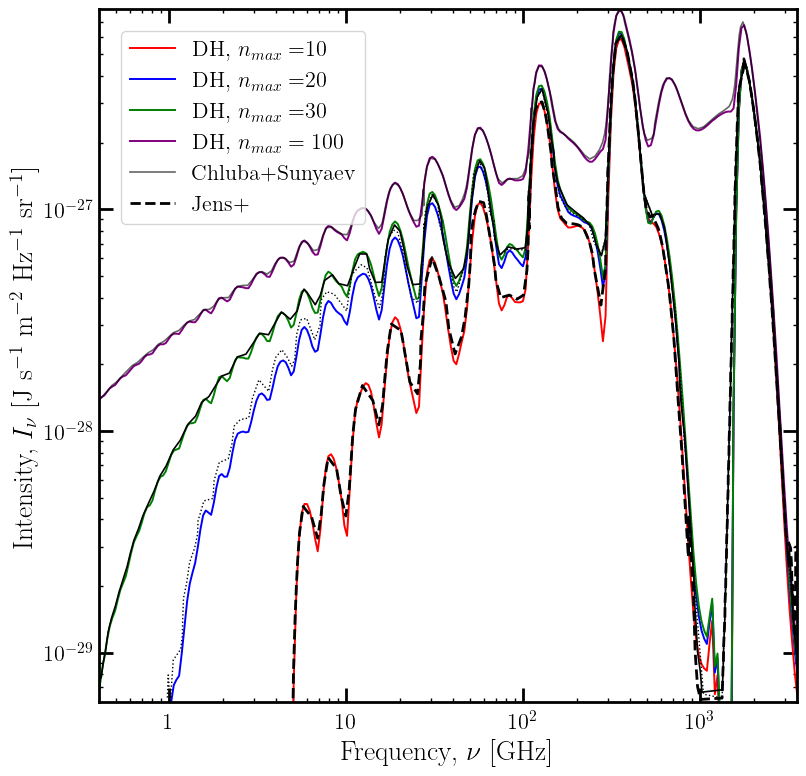

In [113]:
hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
rs_fac = 1300


plt.figure(figsize=(9, 9))
plt.loglog()
plt.xlim([4e-1, 3.5e3])
plt.ylim([6e-30, 8e-27])

# DH generated data
ns = ['10','20','30', '100_2sBF']
colors = ['red', 'blue', 'green', 'purple']
labels = ['DH, $n_{max}=$'+nmax if nmax != '100_2sBF' else 'DH, $n_{max}=100$' for nmax in ns]

for i,nmax in enumerate(ns):
    plt.plot(nu/1e9, convert * distortion_dict[nmax].dNdE,
             color=colors[i], linewidth=1.4, label=labels[i])
# plt.plot(nu/1e9, convert * goods['distortion'].dNdE)

# Data from Jens Chluba et al's papers
plt.plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k',
         linewidth=1.2, label='Chluba+Sunyaev', alpha=0.6)
plt.plot(n10_data[:,0], n10_data[:,1], color='k',
         linewidth=2.0, linestyle='--', label='Jens+')
plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
plt.plot(n30_data[:,0], n30_data[:,1], color='k', linewidth=1.2)
# plt.plot(jens_data[:,0], jens_data[:,1], color='k', linewidth=2.0, linestyle='--')

plt.legend(loc=2)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
if cf>1:
    print('WARNING: There are extra errors from coarsening')
    
if savefig:  
    plt.savefig(fig_dir+'baseline_distortion.pdf')

# 6. Misc

## Detailed Balance checks

In [ ]:
# Detailed Balance

R = atomic.populate_radial(nmax)
BB, BB_2s1s = atomic.populate_bound_bound(nmax, phys.TCMB(rs), R)

print(atomic.A_2s1s(f_gamma, 'up')/atomic.A_2s1s(f_gamma, 'dn')/np.exp(
    -phys.lya_eng/phys.TCMB(rs))-1)

BB_2s1s['dn']/BB_2s1s['up'] * np.exp(-phys.lya_eng/phys.TCMB(rs))-1

## 2s->1s rates

In [ ]:
# distortion when full equilibrium is satisfied (should be zero)

rs = 1500
nH, nB = np.array([phys.nH, phys.nB]) * rs**3
Tr = phys.TCMB(rs)

n1s = phys.xHI_std(rs)
n2s = np.exp(-phys.lya_eng/Tr) * n1s #+ 1e-5

def f_gamma(eng):
    return atomic.f_BB(eng, phys.TCMB(rs))

atomic.N_2s1s(eng_tmp, f_gamma, n2s, n1s)/nB

In [ ]:
# Calcuate the 2s1s rate

def f_gamma(E):
    return 0
phys.width_2s1s_H/atomic.A_2s1s(f_gamma)-1

# Reproduce Jens + Sunyaev's plot
eng_tmp = np.linspace(.001, phys.lya_eng-.001, 100)

plt.figure()

# plt.plot(eng_tmp/phys.lya_eng, phys.dNdE_2s1s(eng_tmp)*phys.lya_eng)
plt.plot(eng_tmp/phys.lya_eng, atomic.phi(eng_tmp/phys.lya_eng))
plt.plot(
    eng_tmp/phys.lya_eng, 
    atomic.phi(eng_tmp/phys.lya_eng) * 
    (1 + f_gamma(eng_tmp)) * 
    (1 + f_gamma(phys.lya_eng - eng_tmp)), 
    'k:'
)

ax=plt.gca()
ax.set_yticks(np.arange(0,5.5,.5));

In [ ]:
%autoreload

# Test out the distortion emitted

x1s = phys.xHI_std(rs)
boltz = np.exp(-phys.lya_eng/phys.TCMB(rs))
x2s = x1s * (boltz + .001)

amp_2s1s = phys.nH/phys.nB * phys.width_2s1s_H * (x2s - x1s * boltz)
amp_2s1s * spec_2s1s.N/atomic.N_2s1s(spec_2s1s.eng, None, x2s, x1s)

In [ ]:
### Show's that Wenzer's new code is correct
# jens_data = download_plot('Full_Distortion')

start_rs = 2000
end_rs = 800
nmax = 30

run_new2s1s = main.evolve(
    DM_process='decay', mDM=2e8,
    lifetime=1e50,
    primary='phot_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=cf,
    distort=True, recfast_TLA=True,
    fexc_switch=False, 
    reprocess_distortion=False, 
    nmax=nmax,
    rtol=1e-6
)

plt.figure(figsize=(7, 7))
ax = plt.gca()
ax.loglog()

ax.plot(jens_data[:,0], jens_data[:,1])
plot_distortion(ax, run_new2s1s)
plot_distortion(ax, run_old2s1s)
plot_distortion(ax, run_old2s1s, run_new2s1s, diff=True, ylim=[1e-32,2e-26])

### Hirata_2005

In [ ]:
(
        ics_sec_phot_tf,
        deposited_ion_arr, deposited_exc_arr, deposited_heat_arr,
        deposited_ICS_arr, ICS_err_vec
    ) = get_elec_cooling_tf(
            eleceng, photeng, rs,
            xHII, xHeII=0,
            raw_thomson_tf=ics_thomson_ref_tf,
            raw_rel_tf=ics_rel_ref_tf,
            raw_engloss_tf=engloss_ref_tf,
            coll_ion_sec_elec_specs=None,
            coll_exc_sec_elec_specs=None,
            ics_engloss_data=ics_engloss_data, 
            #loweng=eleceng[0], 
            spec_2s1s = spec_2s1s,
            simple_ICS=simple_ICS,
            check_conservation_eng=False,
            H_states=H_states
    )

In [ ]:
#Probs that a given state decays ultimately to '2p'
Ps = {'2p': 1.0000, '2s': 0.0, '3p': 0.0,
      '4p': 0.2609,'5p': 0.3078,'6p': 0.3259,
      '7p': 0.3353,'8p': 0.3410,'9p': 0.3448,'10p': 0.3476}

### Testing the TLA assumptions (getting back detailed balance, then Peebles C)

In [203]:
alphas, betas = {}, {}

In [227]:
%autoreload
rs_vec = np.exp(np.arange(np.log(1.555e3), np.log(5), -dlnz))
rs_vec = np.exp(np.linspace(np.log(3e3), np.log(5), 150))

nmax = 100
key = str(nmax)

# if key not in alphas:
alphas[key], betas[key] = np.zeros_like(rs_vec), np.zeros_like(rs_vec)

# Build up the distortion one redshift at a time
for i, rs in enumerate(tqdm(rs_vec)):

    dt = dlnz/phys.hubble(rs)
    xHI = phys.xHI_std(rs)
    Tm = phys.Tm_std(rs)

    alphas[key][i], betas[key][i], transition_spec = atomic.process_MLA(
        rs, dt, xHI, Tm, nmax, spec_2s1s,
        Delta_f=None, cross_check=False,
        include_2s1s=include_2s1s, include_BF=include_BF
    )

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_7059/1734762317.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, rs in enumerate(tqdm(rs_vec)):


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:493: RuntimeWarning: divide by zero encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:497: RuntimeWarning: divide by zero encountered in double_scalars
  K[0][1] = BB['dn'][2][1][0] / tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:523: RuntimeWarning: divide by zero encountered in double_scalars
  b[nl] /= tot_rate


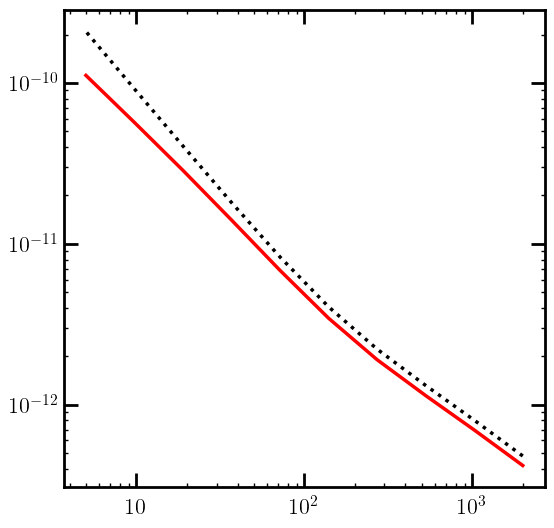

In [228]:
plt.figure()
plt.loglog()

plt.plot(rs_vec, alphas[key+'stim'], color='red')
# plt.plot(rs_vec, betas, color='red', linestyle=':')

plt.plot(rs_vec, phys.alpha_recomb(phys.Tm_std(rs_vec), 'HI'),
         color='k', linestyle=':')
# plt.plot(rs_vec, phys.beta_ion(phys.Tm_std(rs_vec), 'HI'), color='k', linestyle=':')

(1e-07, 0.01)

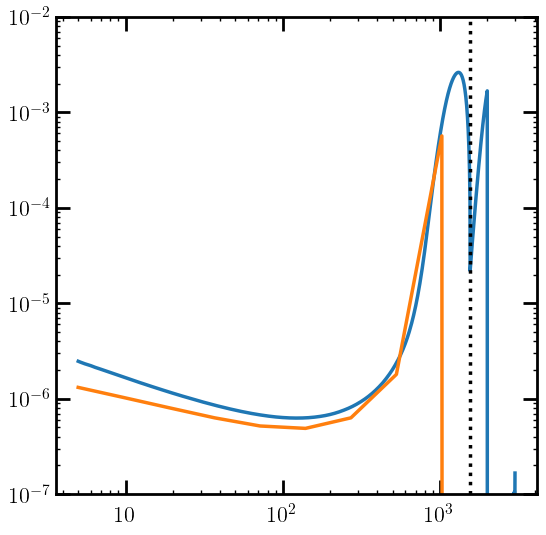

In [242]:
from scipy.interpolate import interp1d

plt.figure()
plt.loglog()

xHII_vec = phys.xHII_std(rs_vec)
xHI_vec = phys.xHI_std(rs_vec)
nH_vec = phys.nH*rs_vec**3
Tm_vec = phys.Tm_std(rs_vec)

# stuff = phys.alpha_recomb(
#     Tm_vec, 'HI') * xHII_vec**2 * nH_vec - \
#     4 * phys.beta_ion(Tm_vec, 'HI') * xHI_vec * np.exp(-phys.lya_eng/phys.TCMB(rs_vec))
    
# stuff *= -phys.peebles_C(xHII_vec, rs_vec)

# plt.plot(rs_vec, phys.dtdz(rs) * stuff)

rs_plot = np.exp(np.arange(np.log(3e3), np.log(5), -.001))
plt.plot(rs_plot, phys.xdot(phys.xHII_std(rs_plot), rs_plot))

stuff = alphas[key] * xHII_vec**2 * nH_vec - betas[key]
stuff *= -phys.dtdz(rs_vec)
# stuff = interp1d(rs_vec, stuff, 'linear')
# mask = rs_plot<rs_vec[0]
plt.plot(rs_vec, stuff)
plt.axvline(1.555e3, linestyle=':', color='k')

plt.ylim([1e-7,1e-2])

# plt.plot(rs_vec[:-1], np.diff(xHII_vec)/np.diff(rs_vec))

In [318]:
%autoreload

end_rs = 4.01
baseline_reion_no_heat = main.evolve(
    DM_process='decay', mDM=2e8,
    lifetime=2.2e45, primary='elec_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=cf, 
    reion_switch=True, reion_method=None, reion_rs=30,
    heat_switch=True, DeltaT = 1*phys.kB, alpha_bk = 1e5,
    xe_reion_func = reion_interps['FlexKnot_early'],
    distort=True, recfast_TLA=True, nmax=nmax
)

  0%|          | 0/414.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:683: RuntimeWarning: overflow encountered in true_divide
  x_full[(states_l == l+1) * (


In [321]:
%autoreload
baseline_reion_heat = main.evolve(
    DM_process='decay', mDM=2e8,
    lifetime=2.2e45, primary='elec_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=cf, 
    reion_switch=True, reion_method=None, reion_rs=30,
    heat_switch=True, DeltaT = 2e4*phys.kB, #alpha_bk = 1e5,
    xe_reion_func = reion_interps['FlexKnot_early'],
    distort=True, recfast_TLA=True, nmax=nmax
)

  0%|          | 0/414.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:683: RuntimeWarning: overflow encountered in true_divide
  x_full[(states_l == l+1) * (
